## Data Input and Setup

In [30]:
#set up
import os 
import numpy as np
import pandas as pd 

In [31]:
#set dictionary 
os.chdir("C:")

In [32]:
#read in the data 
from zipfile import ZipFile
from StringIO import StringIO
import urllib2

r = urllib2.urlopen("https://resources.lendingclub.com/LoanStats3a.csv.zip").read()
file = ZipFile(StringIO(r))
Loan = file.open("LoanStats3a.csv")
Loan = pd.read_csv(Loan, skiprows = 0, header =1 )

In [33]:
#check the data equaty
Loan.head()
Loan.tail()
print(Loan.shape)
#remove rows without loan_amnt
Loan = Loan[(Loan['loan_amnt'] >0)]

(42538, 145)


In [34]:
#reset index
Loan = Loan.reset_index()
del Loan['index']

## 	Data Exploratory Study

### Missing data processing

In [38]:
#check the missing proportions 
missProp = Loan.isnull().sum()
print(missProp)

id                                            42535
member_id                                     42535
loan_amnt                                         0
funded_amnt                                       0
funded_amnt_inv                                   0
term                                              0
int_rate                                          0
installment                                       0
grade                                             0
sub_grade                                         0
emp_title                                      2624
emp_length                                        0
home_ownership                                    0
annual_inc                                        4
verification_status                               0
issue_d                                           0
loan_status                                       0
pymnt_plan                                        0
url                                           42535
desc        

In [39]:
#delete the columns if it is significantly missing 
deleteColumns = set(Loan.columns[missProp >= 30000].values) # use 30k comparing to 42k observations
print(deleteColumns)
print(len(deleteColumns))

set(['hardship_type', 'num_sats', 'num_actv_bc_tl', 'sec_app_earliest_cr_line', 'open_acc_6m', 'hardship_start_date', 'next_pymnt_d', 'mths_since_recent_bc', 'avg_cur_bal', 'hardship_payoff_balance_amount', 'total_bal_ex_mort', 'dti_joint', 'open_il_12m', 'mths_since_last_major_derog', 'num_op_rev_tl', 'num_actv_rev_tl', 'mo_sin_old_il_acct', 'max_bal_bc', 'hardship_dpd', 'sec_app_open_acc', 'num_rev_accts', 'num_bc_tl', 'open_il_24m', 'hardship_loan_status', 'pct_tl_nvr_dlq', 'total_rev_hi_lim', 'sec_app_num_rev_accts', 'debt_settlement_flag_date', 'total_bc_limit', 'payment_plan_start_date', 'num_accts_ever_120_pd', 'num_tl_120dpd_2m', 'hardship_reason', 'sec_app_open_act_il', 'open_rv_12m', 'open_act_il', 'percent_bc_gt_75', 'mths_since_recent_bc_dlq', 'all_util', 'mo_sin_rcnt_rev_tl_op', 'num_tl_90g_dpd_24m', 'mths_since_recent_inq', 'member_id', 'tot_hi_cred_lim', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'sec_app_mths_since_last_major_derog', 'num_il_tl', 'bc_u

In [40]:
#check the data type with moderate missing 
modMissColumns = set(Loan.columns[(missProp > 2000)& (missProp < 30000)])
print(modMissColumns)
print (Loan[list(modMissColumns)].dtypes)

set(['mths_since_last_delinq', 'emp_title', 'desc'])
mths_since_last_delinq    float64
emp_title                  object
desc                       object
dtype: object


In [41]:
#check mths_since_last_delinq    
print(missProp["mths_since_last_delinq"])  
#delete the object types and relative high proportion(more then 50%) of missing 
deleteColumns |= modMissColumns
print(len(deleteColumns))

26926
93


In [42]:
#deal with variables with small proportion of missing 
NoMissCol = list(missProp[missProp == 0].index) 
print(len(NoMissCol))
print(len(set(Loan.columns) - deleteColumns))

#check the columns need to be impute
ImpColTemp = list(set(Loan.columns) - deleteColumns - set(NoMissCol))
print(len(ImpColTemp))

35
52
17


In [45]:
#check the data and decide to use to not 
#print(Loan[ImpCol_Temp].dtypes)
NoImpCol = ['title' ]
deleteColumns |= set(NoImpCol)
ImpColTemp = list(set(Loan.columns) - deleteColumns - set(NoMissCol))
print(len(ImpColTemp))

#change the data types 
#change the revol_util into float 
Loan['revol_util'] = Loan['revol_util'].replace('%','',regex=True).astype('float')/100
#change the date times 
Loan['last_pymnt_d'] = pd.to_datetime(Loan['last_pymnt_d'])
Loan['earliest_cr_line'] = pd.to_datetime(Loan['earliest_cr_line'])
Loan['last_credit_pull_d'] = pd.to_datetime(Loan['last_credit_pull_d'])

ImpColTemp = list(set(Loan.columns) - deleteColumns - set(NoMissCol))
print(Loan[ImpColTemp].dtypes)

16
tax_liens                            float64
pub_rec_bankruptcies                 float64
inq_last_6mths                       float64
pub_rec                              float64
open_acc                             float64
revol_util                           float64
last_pymnt_d                  datetime64[ns]
annual_inc                           float64
total_acc                            float64
earliest_cr_line              datetime64[ns]
acc_now_delinq                       float64
last_credit_pull_d            datetime64[ns]
chargeoff_within_12_mths             float64
collections_12_mths_ex_med           float64
delinq_amnt                          float64
delinq_2yrs                          float64
dtype: object


In [46]:
#impute the numerical variables with median 

###Impute missing cells using column median in columns which are only with minor missing###
ImpColTemp0 = ['last_pymnt_d', 'earliest_cr_line','last_credit_pull_d' ]
ImpColTemp1 = list(set(ImpColTemp) - set(ImpColTemp0)) 

from sklearn import preprocessing as prepro
imp = prepro.Imputer(missing_values="NaN",strategy="median",axis=0)
Loan[ImpColTemp1] = imp.fit_transform(Loan[ImpColTemp1])
Loan[ImpColTemp0] = imp.fit_transform(Loan[ImpColTemp0])

### Check Data Type

In [47]:
#Check the data types without missing 
#print(Loan[NoMissCol].dtypes) 

#change the types if not correct 
Loan['int_rate'] = Loan['int_rate'].replace('%','',regex=True).astype('float')/100

Loan['issue_d'] = pd.to_datetime(Loan['issue_d'])
#ToCat = ['term','grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan', 'purpose',   'debt_settlement_flag']
#Loan[ToCat] = Loan[ToCat].astype('category') 
    
print(Loan[NoMissCol].dtypes) 

loan_amnt                         float64
funded_amnt                       float64
funded_amnt_inv                   float64
term                               object
int_rate                          float64
installment                       float64
grade                              object
sub_grade                          object
emp_length                         object
home_ownership                     object
verification_status                object
issue_d                    datetime64[ns]
loan_status                        object
pymnt_plan                         object
purpose                            object
zip_code                           object
addr_state                         object
dti                               float64
revol_bal                         float64
initial_list_status                object
out_prncp                         float64
out_prncp_inv                     float64
total_pymnt                       float64
total_pymnt_inv                   

In [48]:
#final check the data 
LoanClean = Loan.drop(deleteColumns, axis = 1)
print(max(LoanClean.isnull().sum()))
LoanClean.tail()
print(LoanClean.shape)
print(Loan.shape)
print(len(deleteColumns))

0
(42535, 51)
(42535, 145)
94


## Descriptive Study

### descriptive study of the WV and NM income data 

In [81]:
#find the annual income and number of loan applicants by state 
#LoanClean['addr_state'] = LoanClean['addr_state'].astype('category')
#Find the annule income and number of loan applicants by state 
table = pd.pivot_table(LoanClean, values='annual_inc', 
                     columns=['addr_state'], aggfunc=('mean', 'median','count'))
table.head()
state_income = pd.DataFrame(table)
#write into csv file 
state_income.to_csv("state_income.csv")

The average income by states map are produced by R, with code:
Inc <-read.csv(file = "../states_stats.csv")

incvag<-Inc[,3]
incmed<-Inc[,4]


states2 <- data.frame(state.name, state.x77, incvag, incmed  )


GeoStates3 <- gvisGeoChart(states2, "state.name", "incvag",
                          options=list(region="US", 
                                       displayMode="regions", 
                                       resolution="provinces",
                                       width=600, height=400))
plot(GeoStates3)


GeoStates4 <- gvisGeoChart(states2, "state.name", "incmed",
                          options=list(region="US", 
                                       displayMode="regions", 
                                       resolution="provinces",
                                       width=600, height=400))
plot(GeoStates4)


In [50]:
# Plot the histogram of applicants from West Virginia and New Mexico 
import matplotlib.pyplot as plt

WVinc = LoanClean[(LoanClean['addr_state' ]== 'WV')][ 'annual_inc']
NMinc = LoanClean[(LoanClean['addr_state' ]== 'NM')][ 'annual_inc']

print(WVinc.describe())
print(NMinc.describe())
print(NMinc[NMinc > 180000]) #consider values greater than 200k as outliers for NM income data 
print(NMinc[NMinc <= 180000].describe())

count       187.000000
mean      54235.402941
std       28509.979149
min        7000.000000
25%       32502.000000
50%       48135.000000
75%       73220.500000
max      170000.000000
Name: annual_inc, dtype: float64
count    2.050000e+02
mean     8.193660e+04
std      2.725738e+05
min      1.000000e+04
25%      3.600000e+04
50%      5.400000e+04
75%      7.800000e+04
max      3.900000e+06
Name: annual_inc, dtype: float64
4805      240000.0
14696     470000.0
29708    3900000.0
30695     415000.0
36603     240000.0
Name: annual_inc, dtype: float64
count       200.000000
mean      57660.019600
std       27409.719925
min       10000.000000
25%       36000.000000
50%       53000.000000
75%       75250.000000
max      150000.000000
Name: annual_inc, dtype: float64


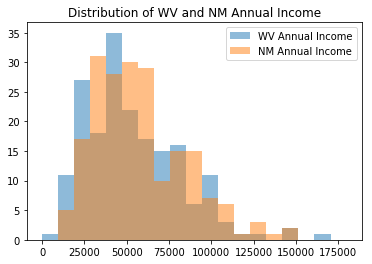

In [51]:
# the two states are quite comparative according to the descriptive statistics 
#did not include the outliers in the NM plot 
bins = np.linspace(0, 180000, 20)
plt.hist(WVinc, bins, alpha=0.5, label='WV Annual Income')
plt.hist(NMinc, bins, alpha=0.5, label='NM Annual Income')
plt.title('Distribution of WV and NM Annual Income')
plt.legend(loc='upper right')
plt.show()

### Test the difference of income

In [52]:
#t test to test the mean differences 
from scipy import stats 
#remove the outliers, and assume the variance are the same 
stats.ttest_ind(WVinc, NMinc[NMinc< 180000])

Ttest_indResult(statistic=-1.2046531458154646, pvalue=0.22907723262886714)

In [53]:
#When the distribution difference of the two states income 
stats.ks_2samp(WVinc, NMinc)

Ks_2sampResult(statistic=0.10914308073562023, pvalue=0.18274133948964583)

## Predictive Study

### Create default variable 

In [54]:
#create a new column called status  from loan_status 
print(LoanClean.loan_status.value_counts())
#in the new status variable 'Fully Paid ' include 'Fully Paid and Does not meet the credit policy. Status:Fully Paid' 
#and 'Charged Off' include 'Charged Off' and 'Does not meet the credit policy. Status:Charged Off'
LoanClean['status'] = LoanClean['loan_status']
LoanClean.loc[LoanClean.status == 'Does not meet the credit policy. Status:Fully Paid', 'status'] = 'Fully Paid'
LoanClean.loc[LoanClean.status == 'Does not meet the credit policy. Status:Charged Off', 'status'] = 'Charged Off'

Fully Paid                                             34116
Charged Off                                             5670
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Name: loan_status, dtype: int64


In [55]:
####Switch "Full Paid" to 1, "Charged Off" to 0###
LoanClean.loc[LoanClean.status=="Fully Paid",'status'] = 0
LoanClean.loc[LoanClean.status=="Charged Off",'status'] = 1
LoanClean.loc[:,'status'] = LoanClean.loc[:,'status'].apply(lambda x:float(x))

###  Feature engineering

In [56]:
print(LoanClean.shape)
#LoanClean.head()
LoanClean.tail()

(42535, 52)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,hardship_flag,disbursement_method,debt_settlement_flag,status
42530,3500.0,3500.0,225.0,36 months,0.1028,113.39,C,C1,< 1 year,RENT,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,0.0
42531,1000.0,1000.0,0.0,36 months,0.0964,32.11,B,B4,< 1 year,RENT,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,0.0
42532,2525.0,2525.0,225.0,36 months,0.0933,80.69,B,B3,< 1 year,RENT,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,0.0
42533,6500.0,6500.0,0.0,36 months,0.0838,204.84,A,A5,< 1 year,NONE,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,0.0
42534,5000.0,5000.0,0.0,36 months,0.0775,156.11,A,A3,10+ years,MORTGAGE,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,0.0


In [57]:
LoanClean.dtypes

loan_amnt                            float64
funded_amnt                          float64
funded_amnt_inv                      float64
term                                  object
int_rate                             float64
installment                          float64
grade                                 object
sub_grade                             object
emp_length                            object
home_ownership                        object
annual_inc                           float64
verification_status                   object
issue_d                       datetime64[ns]
loan_status                           object
pymnt_plan                            object
purpose                               object
zip_code                              object
addr_state                            object
dti                                  float64
delinq_2yrs                          float64
earliest_cr_line                     float64
inq_last_6mths                       float64
open_acc  

In [58]:
#Screen the variables: check the type, values takes 
Vars = list(LoanClean.columns.values)
for i in range(len(Vars)):
    print(LoanClean[Vars[i]].value_counts())

10000.0    3016
12000.0    2439
5000.0     2260
6000.0     2037
15000.0    2012
20000.0    1724
8000.0     1699
25000.0    1499
4000.0     1230
3000.0     1134
7000.0     1089
16000.0     884
9000.0      715
35000.0     685
18000.0     668
14000.0     660
7500.0      623
2000.0      586
24000.0     508
4800.0      465
2500.0      455
13000.0     413
3500.0      381
30000.0     380
7200.0      377
9600.0      376
1000.0      327
1500.0      322
11000.0     311
3600.0      311
           ... 
17175.0       1
17900.0       1
19925.0       1
950.0         1
13425.0       1
21225.0       1
10350.0       1
3475.0        1
4875.0        1
29375.0       1
32250.0       1
17075.0       1
14850.0       1
17925.0       1
12625.0       1
19975.0       1
19100.0       1
2625.0        1
5725.0        1
15150.0       1
32275.0       1
3225.0        1
15675.0       1
26200.0       1
31325.0       1
750.0         1
4675.0        1
17975.0       1
14625.0       1
725.0         1
Name: loan_amnt, Length:

In [59]:
#delete variables
DeleteCol = ['loan_status', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'collections_12_mths_ex_med', 
             'policy_code', 'application_type', 'chargeoff_within_12_mths', 'hardship_flag',  'disbursement_method','zip_code']
#temperature variables 
TempCol = ['issue_d', 'last_pymnt_d', 'last_credit_pull_d', 'earliest_cr_line']

LoanClean2 = LoanClean.copy()
LoanClean2.drop(DeleteCol, axis=1, inplace=True)

#delete the TempCol for now 
LoanClean2.drop(TempCol, axis=1, inplace=True)

In [60]:
LoanClean2.dtypes

loan_amnt                  float64
funded_amnt                float64
funded_amnt_inv            float64
term                        object
int_rate                   float64
installment                float64
grade                       object
sub_grade                   object
emp_length                  object
home_ownership              object
annual_inc                 float64
verification_status         object
pymnt_plan                  object
purpose                     object
addr_state                  object
dti                        float64
delinq_2yrs                float64
inq_last_6mths             float64
open_acc                   float64
pub_rec                    float64
revol_bal                  float64
revol_util                 float64
total_acc                  float64
total_pymnt                float64
total_pymnt_inv            float64
total_rec_prncp            float64
total_rec_int              float64
total_rec_late_fee         float64
recoveries          

In [61]:
#term 
print(LoanClean2['term'].describe()) 
####remove "month" for "term"####
def remove_month(string):
    if type(string) == str:
        return(string[1:3])
    else:
        return(string)
LoanClean2.loc[:,'term'] = LoanClean2.loc[:,'term'].apply(lambda x:remove_month(x))
LoanClean2.loc[:,'term'] = LoanClean2.loc[:,'term'].apply(lambda x:str(x))

count          42535
unique             2
top        36 months
freq           31534
Name: term, dtype: object


In [62]:
#check the emp_length variable 
print(LoanClean2.emp_length.value_counts())
# change emp_length into numerical 
def unifEmplength(subject):
    if(subject == "10+ years"):
        return(10)
    elif(subject == "9 years"):
        return(9)
    elif(subject == "8 years"):
        return(8)
    elif(subject == "7 years"):
        return(7)
    elif(subject == "6 years"):
        return(6)    
    elif(subject == "5 years"):
        return(5)
    elif(subject == "4 years"):
        return(4)    
    elif(subject == "3 years"):
        return(3)
    elif(subject == "2 years"):
        return(2)    
    elif(subject == "1 year"):
        return(1)
    elif(subject == "< 1 year"):
        return(0)
    else:
        return(subject)
    
LoanClean2['emp_length'] = LoanClean2['emp_length'].apply(lambda x: unifEmplength(x))
temp = np.median(LoanClean2[(LoanClean2.emp_length != 'n/a')].emp_length.apply(lambda x:float(x)))
LoanClean2.loc[LoanClean2.emp_length == 'n/a', 'emp_length'] = temp
print(LoanClean2.emp_length.value_counts())

10+ years    9369
< 1 year     5062
2 years      4743
3 years      4364
4 years      3649
1 year       3595
5 years      3458
6 years      2375
7 years      1875
8 years      1592
9 years      1341
n/a          1112
Name: emp_length, dtype: int64
10    9369
0     5062
4     4761
2     4743
3     4364
1     3595
5     3458
6     2375
7     1875
8     1592
9     1341
Name: emp_length, dtype: int64


In [63]:
#Code the categorical variables 
#LoanClean.dtypes
#find out the object types 
cat_columns = LoanClean2.dtypes.index[LoanClean2.dtypes==object]
cat_columns

Index([u'term', u'grade', u'sub_grade', u'emp_length', u'home_ownership',
       u'verification_status', u'pymnt_plan', u'purpose', u'addr_state',
       u'debt_settlement_flag'],
      dtype='object')

In [64]:
from sklearn import metrics, preprocessing, cross_validation
LBL = preprocessing.LabelEncoder()
LE_map=dict()
LE_map2 = dict()
for cat_col in cat_columns:
    LoanClean2[cat_col] = LBL.fit_transform(LoanClean2[cat_col])
    LE_map[cat_col]=dict(zip(LBL.classes_, LBL.transform(LBL.classes_)))
    LE_map2[cat_col]= LBL.classes_
LoanClean2.dtypes

loan_amnt                  float64
funded_amnt                float64
funded_amnt_inv            float64
term                         int64
int_rate                   float64
installment                float64
grade                        int64
sub_grade                    int64
emp_length                   int64
home_ownership               int64
annual_inc                 float64
verification_status          int64
pymnt_plan                   int64
purpose                      int64
addr_state                   int64
dti                        float64
delinq_2yrs                float64
inq_last_6mths             float64
open_acc                   float64
pub_rec                    float64
revol_bal                  float64
revol_util                 float64
total_acc                  float64
total_pymnt                float64
total_pymnt_inv            float64
total_rec_prncp            float64
total_rec_int              float64
total_rec_late_fee         float64
recoveries          

In [66]:
##One Hot Encoding on categorical variables##
OHE = preprocessing.OneHotEncoder(sparse=False)
OHE.fit(LoanClean2[cat_columns])
OHE_data=OHE.transform(LoanClean2[cat_columns])
OHE_vars = [var + '_' + str(level).replace(' ','_') for var in cat_columns for level in LE_map2[var]]

In [67]:
LoanClean3 = pd.concat((LoanClean2, pd.DataFrame(OHE_data,columns=OHE_vars)), axis = 1)
LoanClean3 = LoanClean3.drop(cat_columns,axis = 1)
LoanClean3.tail()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,...,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,debt_settlement_flag_N,debt_settlement_flag_Y
42530,3500.0,3500.0,225.0,0.1028,113.39,180000.0,10.00,0.0,1.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
42531,1000.0,1000.0,0.0,0.0964,32.11,12000.0,10.00,0.0,1.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
42532,2525.0,2525.0,225.0,0.0933,80.69,110000.0,10.00,0.0,1.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
42533,6500.0,6500.0,0.0,0.0838,204.84,59000.0,4.00,0.0,1.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
42534,5000.0,5000.0,0.0,0.0775,156.11,70000.0,8.81,0.0,1.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [68]:
list(LoanClean3.columns.values)

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'acc_now_delinq',
 'delinq_amnt',
 'pub_rec_bankruptcies',
 'tax_liens',
 'status',
 'term_36',
 'term_60',
 'grade_A',
 'grade_B',
 'grade_C',
 'grade_D',
 'grade_E',
 'grade_F',
 'grade_G',
 'sub_grade_A1',
 'sub_grade_A2',
 'sub_grade_A3',
 'sub_grade_A4',
 'sub_grade_A5',
 'sub_grade_B1',
 'sub_grade_B2',
 'sub_grade_B3',
 'sub_grade_B4',
 'sub_grade_B5',
 'sub_grade_C1',
 'sub_grade_C2',
 'sub_grade_C3',
 'sub_grade_C4',
 'sub_grade_C5',
 'sub_grade_D1',
 'sub_grade_D2',
 'sub_grade_D3',
 'sub_grade_D4',
 'sub_grade_D5',
 'sub_grade_E1',
 'sub_grade_E2',
 'sub_grade_E3',
 'sub_grade_E4',
 'sub_grade_E5',
 'sub_grade_F1',


## Run a random forest model 

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [86]:
# double check the missing values 
MissCount = LoanClean3.isnull().sum()
max(MissCount)

0

In [88]:
#create the model data 
#delete variable related to dependent variables 
LoanModel = LoanClean3.copy()
#LoanModel.head()
LoanModel.drop(['recoveries', 'collection_recovery_fee', 'total_rec_prncp', 'total_rec_prncp', 'total_pymnt', 'total_pymnt_inv', 'total_rec_late_fee'  ], axis = 1, inplace=True)

In [89]:
# train test split 
X = LoanModel.drop('status',axis=1)
Y = LoanModel.status

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1234)

In [90]:
#define a search
def search_model(x_train, y_train, est, param_grid, n_jobs, cv):
    model = GridSearchCV(estimator  = est,
                                     param_grid = param_grid,
                                     scoring = 'f1_weighted',
                                     verbose = 10,
                                     n_jobs = n_jobs,
                                     iid = True,
                                     cv = cv)
    # Fit Grid Search Model
    model.fit(x_train, y_train)   
    return model

In [113]:
param_grid = {'n_estimators':[10, 50, 100, 200, 400],
              'criterion':['gini'],
              'max_depth': [5, 10, 20],
              'min_samples_leaf': [2, 5, 10, 20, 50],
              'min_samples_split': [2, 4, 6], 
             'class_weight': [{0:5, 1:1},{0:10, 1:1}, {0:50, 1:5}, {0:100, 1:5}, {0:1, 1:10},  {0:1, 1:30}] }

param_grid = {'n_estimators':[20,60,100],
             'criterion':['gini'],
             'class_weight': [{0:5, 1:1}, {0:10, 1:1},  {0:50, 1:5}, ]}

RF = search_model(x_train.values
            , y_train.values
            , RandomForestClassifier()
            , param_grid
            , -1
            , 5)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  43 out of  45 | elapsed:  1.5min remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.6min finished


In [114]:
RF.cv_results_

{'mean_fit_time': array([  2.36360002,   7.14780002,  11.32080002,   2.4598    ,
          7.12600002,  11.97539997,   2.60020003,   7.99880004,  12.42799997]),
 'mean_score_time': array([ 0.07100005,  0.2072    ,  0.33380003,  0.07340002,  0.19180002,
         0.35139995,  0.07379999,  0.23940001,  0.32680001]),
 'mean_test_score': array([ 0.87048978,  0.87277298,  0.87661338,  0.86712747,  0.87135845,
         0.8737848 ,  0.8671997 ,  0.8720949 ,  0.87273432]),
 'mean_train_score': array([ 0.99733683,  0.99993282,  0.9999916 ,  0.9972185 ,  0.99992442,
         1.        ,  0.99707455,  0.99989922,  0.9999916 ]),
 'param_class_weight': masked_array(data = [{0: 5, 1: 1} {0: 5, 1: 1} {0: 5, 1: 1} {0: 10, 1: 1} {0: 10, 1: 1}
  {0: 10, 1: 1} {0: 50, 1: 5} {0: 50, 1: 5} {0: 50, 1: 5}],
              mask = [False False False False False False False False False],
        fill_value = ?),
 'param_criterion': masked_array(data = ['gini' 'gini' 'gini' 'gini' 'gini' 'gini' 'gini' 'gini' 'gini

In [115]:
from sklearn import metrics
print(metrics.classification_report(y_train,RF.predict(x_train)))

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     25285
        1.0       1.00      1.00      1.00      4489

avg / total       1.00      1.00      1.00     29774



In [116]:
#check the model fitting on the test data 
print(metrics.classification_report(y_test,RF.predict(x_test)))

             precision    recall  f1-score   support

        0.0       0.90      0.99      0.94     10819
        1.0       0.86      0.37      0.52      1942

avg / total       0.89      0.90      0.88     12761



In [122]:
#check the best parameters 
print(RF.best_estimator_)
print(RF.best_params_)

RandomForestClassifier(bootstrap=True, class_weight={0: 5, 1: 1},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
{'n_estimators': 100, 'criterion': 'gini', 'class_weight': {0: 5, 1: 1}}


In [121]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, RF.predict(x_test)))

[[10705   114]
 [ 1214   728]]


In [125]:
clf = RandomForestClassifier(n_estimators = 100,criterion='gini', class_weight= {0:5, 1: 1} )
clf.fit(x_train, y_train)

importance = clf.feature_importances_
importance = pd.DataFrame(importance, index=x_train.columns, 
                          columns=["Importance"])

#importance["Std"] = np.std([tree.feature_importances_  for tree in clf.estimators_], axis=0)

C:\Users\yyang\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app


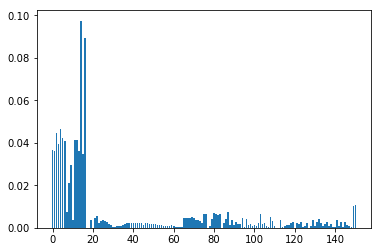

In [126]:
x = range(importance.shape[0])
y = importance.ix[:, 0]
plt.bar(x, y, align="center")
plt.show()

In [98]:
#print the important variables 
print(importance[importance.Importance > .005])
print(importance[importance.Importance > .005].sum())

                                     Importance
loan_amnt                              0.034580
funded_amnt                            0.036929
funded_amnt_inv                        0.045176
int_rate                               0.040435
installment                            0.046602
annual_inc                             0.041941
dti                                    0.039393
delinq_2yrs                            0.007269
inq_last_6mths                         0.020047
open_acc                               0.030352
revol_bal                              0.039415
revol_util                             0.041617
total_acc                              0.035515
total_rec_int                          0.099629
total_rec_late_fee                     0.032630
last_pymnt_amnt                        0.095837
term_36                                0.006220
term_60                                0.005779
emp_length_0                           0.005107
emp_length_4                           0

In [177]:
VarSub = importance.index[importance['Importance'] > .005].tolist()
VarSub

['total_rec_int',
 'last_pymnt_amnt',
 'installment',
 'int_rate',
 'funded_amnt_inv',
 'revol_util',
 'annual_inc',
 'revol_bal',
 'dti',
 'total_acc',
 'total_rec_late_fee',
 'funded_amnt',
 'loan_amnt',
 'open_acc',
 'inq_last_6mths',
 'debt_settlement_flag_N',
 'debt_settlement_flag_Y',
 'delinq_2yrs',
 'purpose_debt_consolidation',
 'addr_state_CA',
 'emp_length_10',
 'home_ownership_RENT',
 'home_ownership_MORTGAGE',
 'verification_status_Source_Verified',
 'verification_status_Not_Verified',
 'verification_status_Verified',
 'emp_length_4',
 'emp_length_0']

In [178]:
#create a subset of the variables 
LoanModelSub = LoanModel[(VarSub +['status'])]

In [182]:
 LoanModelSub =LoanModelSub.drop('total_rec_late_fee', axis = 1)
LoanModelSub.columns.values

array(['total_rec_int', 'last_pymnt_amnt', 'installment', 'int_rate',
       'funded_amnt_inv', 'revol_util', 'annual_inc', 'revol_bal', 'dti',
       'total_acc', 'funded_amnt', 'loan_amnt', 'open_acc',
       'inq_last_6mths', 'debt_settlement_flag_N',
       'debt_settlement_flag_Y', 'delinq_2yrs',
       'purpose_debt_consolidation', 'addr_state_CA', 'emp_length_10',
       'home_ownership_RENT', 'home_ownership_MORTGAGE',
       'verification_status_Source_Verified',
       'verification_status_Not_Verified', 'verification_status_Verified',
       'emp_length_4', 'emp_length_0', 'status'], dtype=object)

In [183]:
# train test split 
X = LoanModelSub.drop('status',axis=1)
Y = LoanModelSub.status

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1234)

In [184]:
clf = RandomForestClassifier(n_estimators = 200,criterion='gini', class_weight= {0:10, 1: 1} )
clf.fit(x_train, y_train)

importance = clf.feature_importances_
importance = pd.DataFrame(importance, index=x_train.columns, 
                          columns=["Importance"])

#importance["Std"] = np.std([tree.feature_importances_  for tree in clf.estimators_], axis=0)

In [185]:
print(metrics.classification_report(y_train,clf.predict(x_train)))

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     25285
        1.0       1.00      1.00      1.00      4489

avg / total       1.00      1.00      1.00     29774



In [186]:
print(metrics.classification_report(y_test,clf.predict(x_test)))

             precision    recall  f1-score   support

        0.0       0.92      0.98      0.95     10819
        1.0       0.85      0.49      0.63      1942

avg / total       0.91      0.91      0.90     12761



In [187]:
print(confusion_matrix(y_test, clf.predict(x_test)))

[[10654   165]
 [  983   959]]


C:\Users\yyang\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


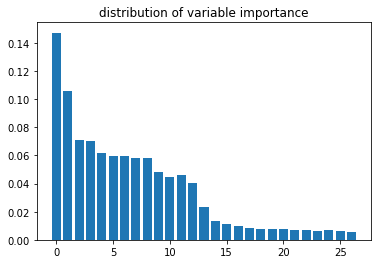

In [188]:
importance = clf.feature_importances_
importance = pd.DataFrame(importance, index=x_train.columns, 
                          columns=["Importance"])

x = range(importance.shape[0])
y = importance.ix[:, 0]
plt.bar(x, y, align="center")
plt.title('distribution of variable importance')
plt.show()

In [189]:
#check the variable importance
importance = importance.sort_values(['Importance'], ascending = 0)
importance[importance.Importance > .02]
Implist = importance.index[importance['Importance'] > .0145].tolist()
len(Implist)

14

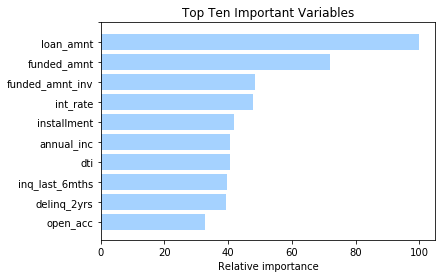

In [190]:
# Top Ten
feature_importance = clf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())

indices = np.argsort(feature_importance)[-10:]
plt.barh(np.arange(10), feature_importance[indices],color='dodgerblue',alpha=.4)
plt.yticks(np.arange(10 + 0.25), np.array(LoanModel.columns)[indices])
_ = plt.xlabel('Relative importance'), plt.title('Top Ten Important Variables')
plt.show()

In [191]:
#predict the proabability of default 0/1 
PredDefault = clf.predict_proba(X)

In [192]:
from sklearn.preprocessing import binarize
y_pred_prob = PredDefault[:, 1]
y_pred_label =  binarize(y_pred_prob, 0.3)[0]
y_pred_label[:10]

C:\Users\yyang\AppData\Local\Enthought\Canopy\User\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.])

In [193]:
print(confusion_matrix(Y, y_pred_label))

[[35115   989]
 [  468  5963]]


In [399]:
PredDefault_test = clf.predict_proba(x_test)
y_pred_prob = PredDefault_test[:, 1]
y_pred_label =  binarize(y_pred_prob, 0.2)[0]
print(confusion_matrix(y_test, y_pred_label))
print(metrics.classification_report(y_test, y_pred_label))

[[8788 2031]
 [ 199 1743]]
             precision    recall  f1-score   support

        0.0       0.98      0.81      0.89     10819
        1.0       0.46      0.90      0.61      1942

avg / total       0.90      0.83      0.85     12761



C:\Users\yyang\AppData\Local\Enthought\Canopy\User\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


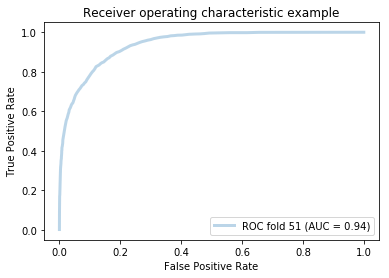

In [195]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc


probas_test = clf.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_test[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=3, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Risk Analysis 

### Descriptive analysis


#### study the by district

In [201]:
Drate = pd.pivot_table(LoanClean, values='status', 
                     columns=['addr_state'], aggfunc=('mean', 'count'))

Drate = pd.DataFrame(Drate)
Drate2 =  Drate.transpose()
#write into csv file 
Drate.to_csv("Drate.csv")
Drate2 

addr_state,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
count,86.000000,484.000000,261.000000,933.000000,7429.000000,857.000000,816.000000,224.000000,136.000000,3104.000000,...,67.00000,32.0000,2915.000000,278.000000,1487.000000,57.000000,888.000000,516.000000,187.000000,87.000000
mean,0.197674,0.128099,0.130268,0.153269,0.165837,0.129522,0.129902,0.075893,0.117647,0.187178,...,0.19403,0.1875,0.129331,0.165468,0.130464,0.122807,0.161036,0.149225,0.122995,0.045977


In [217]:
#find out the large market  
Market_L = Drate2[Drate2['count'] > 1000]
print(Market_L)

             count      mean
addr_state                  
CA          7429.0  0.165837
FL          3104.0  0.187178
GA          1503.0  0.166334
IL          1672.0  0.139952
MA          1438.0  0.128651
MD          1125.0  0.165333
NJ          1988.0  0.154930
NY          4065.0  0.137269
OH          1329.0  0.130926
PA          1651.0  0.136281
TX          2915.0  0.129331
VA          1487.0  0.130464


In [221]:
# the large market with small default rate 
Market_L[Market_L['mean' ] < .14]

,count,mean
addr_state,,
IL,1672.0,0.139952
MA,1438.0,0.128651
NY,4065.0,0.137269
OH,1329.0,0.130926
PA,1651.0,0.136281
TX,2915.0,0.129331
VA,1487.0,0.130464


#### Create the map plot by states 

The heatmap code is created by R

require(datasets)

library(googleVis)

DefaultState <-read.csv(file = "state_proportion.csv")

defaultRate<-DefaultState[,3]

applicants<- DefaultState[,2]


states2 <- data.frame(state.name, state.x77, defaultRate, applicants  )

GeoStates <- gvisGeoChart(states2, "state.name", "defaultRate",
                          options=list(region="US", 
                                       displayMode="regions", 
                                       resolution="provinces",
                                       width=600, height=400))
                                       
plot(GeoStates)

GeoStates2 <- gvisGeoChart(states2, "state.name", "applicants",
                          options=list(region="US", 
                                       displayMode="regions", 
                                       resolution="provinces",
                                       width=600, height=400))
                                       
plot(GeoStates2)

#### Analysis by Grade 

In [230]:
Grade_rate = pd.pivot_table(LoanClean, values='status', 
                     columns=['grade'], aggfunc=('mean', 'count'))

Grade_rate = pd.DataFrame(Grade_rate)
Grade_rate2 =  Grade_rate.transpose()
Grade_rate2

,count,mean
grade,,
A,10183.0,0.059904
B,12389.0,0.122528
C,8740.0,0.172082
D,6016.0,0.220578
E,3394.0,0.260165
F,1301.0,0.319754
G,512.0,0.337891


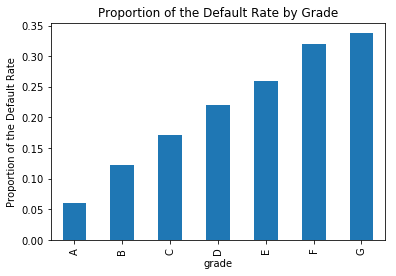

In [232]:
#create bar plot
var = LoanClean.groupby('grade').status.mean()
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Grade')
ax1.set_ylabel('Proportion of the Default Rate')
ax1.set_title('Proportion of the Default Rate by Grade')
var.plot(kind='bar')
plt.show()

In [255]:
Grade_rate2['Ndefault'] = Grade_rate2['count'] * Grade_rate2['mean']
Grade_rate2

,count,mean,Ndefault
grade,,,
A,10183.0,0.059904,610.0
B,12389.0,0.122528,1518.0
C,8740.0,0.172082,1504.0
D,6016.0,0.220578,1327.0
E,3394.0,0.260165,883.0
F,1301.0,0.319754,416.0
G,512.0,0.337891,173.0


In [256]:
# test the proportion are the same 
Grade_rate2['Ndefault'] = Grade_rate2['count'] * Grade_rate2['mean']
grade_arr = np.array(Grade_rate2)
grade_arr = np.delete(grade_arr, 1, axis = 1 )
stats.chi2_contingency(grade_arr)

(1253.0227052331177,
 1.5987884076332751e-267,
 6L,
 array([[  9375.49023812,   1417.50976188],
        [ 12080.50984356,   1826.49015644],
        [  8898.59371809,   1345.40628191],
        [  6378.59953846,    964.40046154],
        [  3715.27580362,    561.72419638],
        [  1491.49603807,    225.50396193],
        [   595.03482008,     89.96517992]]))

In [233]:
Gradesub_rate = pd.pivot_table(LoanClean, values='status', 
                     columns=['sub_grade'], aggfunc=('mean', 'count'))

Gradesub_rate = pd.DataFrame(Gradesub_rate)
Gradesub_rate2 =  Gradesub_rate.transpose()
Gradesub_rate2


,count,mean
sub_grade,,
A1,1142.0,0.026270
A2,1520.0,0.050658
A3,1823.0,0.056500
A4,2905.0,0.061274
A5,2793.0,0.079484
B1,1882.0,0.098831
B2,2113.0,0.113109
B3,2997.0,0.119786
B4,2590.0,0.136680


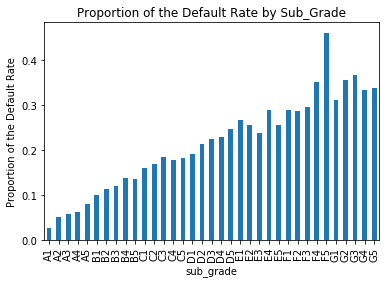

In [239]:
var = LoanClean.groupby('sub_grade').status.mean()
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Sub_Grade')
ax1.set_ylabel('Proportion of the Default Rate')
ax1.set_title('Proportion of the Default Rate by Sub_Grade')
var.plot(kind='bar')
plt.show()

#### study by home ownership

In [244]:
Home_rate = pd.pivot_table(LoanClean, values='status', 
                     columns=['home_ownership'], aggfunc=('mean', 'count'))
Home_rate = pd.DataFrame(Home_rate)
Home_rate =  Home_rate.transpose()
Home_rate['Ndefault'] = Home_rate['count'] * Home_rate['mean']
Home_rate

,count,mean,Ndefault
home_ownership,,,
MORTGAGE,18959.0,0.142360,2699.0
NONE,8.0,0.125000,1.0
OTHER,136.0,0.213235,29.0
OWN,3251.0,0.152261,495.0
RENT,20181.0,0.158912,3207.0


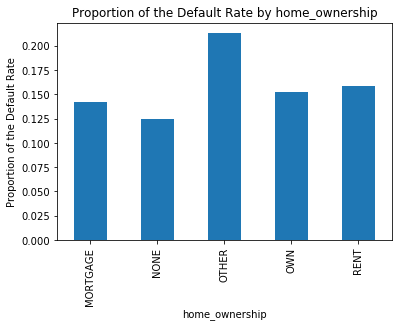

In [236]:
var = LoanClean.groupby('home_ownership').status.mean()
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Home Ownership')
ax1.set_ylabel('Proportion of the Default Rate')
ax1.set_title('Proportion of the Default Rate by Home Ownership')
var.plot(kind='bar')
plt.show()

In [250]:
# test the proportion are the same 
home_arr = np.array(Home_rate)
home_arr = np.delete(home_arr, 1, axis = 1 )
stats.chi2_contingency(home_arr)

(18.334401875182866,
 0.0010615406392784324,
 4L,
 array([[  1.88135243e+04,   2.84447572e+03],
        [  7.81797574e+00,   1.18202426e+00],
        [  1.43329555e+02,   2.16704448e+01],
        [  3.25401524e+03,   4.91984765e+02],
        [  2.03163130e+04,   3.07168705e+03]]))

#### purpose

In [257]:
purpose_rate = pd.pivot_table(LoanClean, values='status', 
                     columns=['purpose'], aggfunc=('mean', 'count'))
purpose_rate = pd.DataFrame(purpose_rate)
purpose_rate =  purpose_rate.transpose()
purpose_rate['Ndefault'] = purpose_rate['count'] * purpose_rate['mean']
purpose_rate

,count,mean,Ndefault
purpose,,,
car,1615.0,0.107121,173.0
credit_card,5477.0,0.112653,617.0
debt_consolidation,19776.0,0.155947,3084.0
educational,422.0,0.208531,88.0
home_improvement,3199.0,0.131916,422.0
house,426.0,0.164319,70.0
major_purchase,2311.0,0.106015,245.0
medical,753.0,0.169987,128.0
moving,629.0,0.170111,107.0


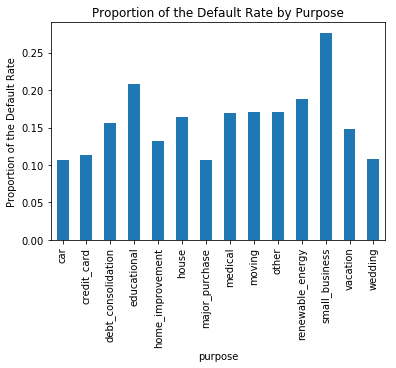

In [258]:
var = LoanClean.groupby('purpose').status.mean()
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Purpose')
ax1.set_ylabel('Proportion of the Default Rate')
ax1.set_title('Proportion of the Default Rate by Purpose')
var.plot(kind='bar')
plt.show()

In [259]:
purpose_arr = np.array(purpose_rate)
purpose_arr = np.delete(purpose_arr, 1, axis = 1 )
stats.chi2_contingency(purpose_arr)

(299.7680455805716,
 2.6900115502497008e-56,
 13L,
 array([[  1.55317118e+03,   2.34828820e+02],
        [  5.29363824e+03,   8.00361761e+02],
        [  1.98576584e+04,   3.00234162e+03],
        [  4.43018625e+02,   6.69813748e+01],
        [  3.14543224e+03,   4.75567761e+02],
        [  4.30857330e+02,   6.51426704e+01],
        [  2.22030511e+03,   3.35694890e+02],
        [  7.65292958e+02,   1.15707042e+02],
        [  6.39336683e+02,   9.66633174e+01],
        [  4.50228536e+03,   6.80714639e+02],
        [  1.09451660e+02,   1.65483397e+01],
        [  2.20901248e+03,   3.33987522e+02],
        [  3.98716763e+02,   6.02832373e+01],
        [  9.66823000e+02,   1.46177000e+02]]))

#### Risk Simulation

In [368]:
#consider a special case then threshold is 0.2 
threshold = 0.2
PredDefault= clf.predict_proba(X)
y_pred_prob = PredDefault[:, 1]
y_pred_label =  binarize(y_pred_prob, 0.2)[0]
#print(confusion_matrix(Y, y_pred_label))
#print(metrics.classification_report(Y, y_pred_label))
y_pred_prob[1:10]

C:\Users\yyang\AppData\Local\Enthought\Canopy\User\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 0.78 ,  0.06 ,  0.035,  0.225,  0.065,  0.   ,  0.11 ,  0.83 ,
        0.855])

In [369]:
y_lend = 1-y_pred_label
print(len(y_lend))
y_lend[:10]

42535


array([ 1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  0.])

In [289]:
#define the data for risk analysis 
RiskData = LoanClean.copy()
RiskData['profit'] = RiskData['total_pymnt'] - RiskData['funded_amnt']
RiskData= pd.concat((RiskData, pd.DataFrame(y_lend, columns=['Lend'])), axis = 1)
RiskData['gain'] = RiskData['profit']*RiskData['Lend']

In [301]:
# the average profit is 
np.mean(RiskData['gain'])

1741.3929503248469

In [382]:
### run simulations 
thresh = list(np.arange(0.05, .5, .001))
RiskSimu = RiskData['profit']

In [383]:
for i in thresh:
    y_lend = 1- binarize(PredDefault[:, 1], i)[0]
    RiskSimu= pd.concat((RiskSimu, pd.DataFrame(y_lend, columns=['Lend' + '_' + str(i)])), axis = 1)

C:\Users\yyang\AppData\Local\Enthought\Canopy\User\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\yyang\AppData\Local\Enthought\Canopy\User\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\yyang\AppData\Local\Enthought\Canopy\User\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single

In [384]:
RiskSimu.head()

,profit,Lend_0.05,Lend_0.051,Lend_0.052,Lend_0.053,Lend_0.054,Lend_0.055,Lend_0.056,Lend_0.057,Lend_0.058,...,Lend_0.49,Lend_0.491,Lend_0.492,Lend_0.493,Lend_0.494,Lend_0.495,Lend_0.496,Lend_0.497,Lend_0.498,Lend_0.499
0,863.155187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,-1485.470000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,605.666844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,2231.890000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1066.908161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [385]:
gain = []
for j in range(1, (len(thresh) +1)):
    gain.append(np.mean(RiskSimu['profit'] * RiskSimu.iloc[:, j]))

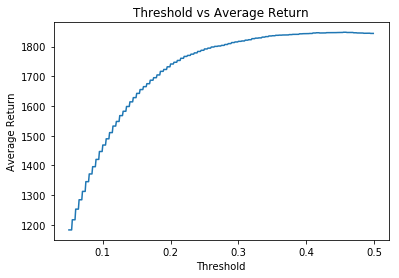

In [391]:
#plot the average gain
plt.plot(thresh, gain )
plt.xlabel('Threshold')
plt.ylabel('Average Return')
plt.title('Threshold vs Average Return')
plt.show()

#### check the return by groups

In [392]:
RiskData.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,delinq_amnt,pub_rec_bankruptcies,tax_liens,hardship_flag,disbursement_method,debt_settlement_flag,status,profit,Lend,gain
0,5000.0,5000.0,4975.0,36 months,0.1065,162.87,B,B2,10+ years,RENT,...,0.0,0.0,0.0,N,Cash,N,0.0,863.155187,1.0,863.155187
1,2500.0,2500.0,2500.0,60 months,0.1527,59.83,C,C4,< 1 year,RENT,...,0.0,0.0,0.0,N,Cash,N,1.0,-1485.470000,0.0,-0.000000
2,2400.0,2400.0,2400.0,36 months,0.1596,84.33,C,C5,10+ years,RENT,...,0.0,0.0,0.0,N,Cash,N,0.0,605.666844,1.0,605.666844
3,10000.0,10000.0,10000.0,36 months,0.1349,339.31,C,C1,10+ years,RENT,...,0.0,0.0,0.0,N,Cash,N,0.0,2231.890000,1.0,2231.890000
4,3000.0,3000.0,3000.0,60 months,0.1269,67.79,B,B5,1 year,RENT,...,0.0,0.0,0.0,N,Cash,N,0.0,1066.908161,0.0,0.000000


In [393]:
Gain_state = pd.pivot_table(RiskData, values='gain', 
                     columns=['addr_state'], aggfunc=('mean'))

Gain_state = pd.DataFrame(Gain_state)
Gain_state =  Gain_state.transpose()
#write into csv file 
Gain_state.to_csv("Gain_state.csv")


,gain
addr_state,
AK,1997.439869
AL,1771.706769
AR,1678.785212
AZ,1732.733411
CA,1702.548556
CO,1791.608302
CT,1893.910836
DC,2021.339622
DE,1749.564475


In [394]:
#by Loan Group
Gain_grade = pd.pivot_table(RiskData, values='gain', 
                     columns=['grade'], aggfunc=('mean'))

Gain_grade = pd.DataFrame(Gain_grade)
Gain_grade =  Gain_grade.transpose()

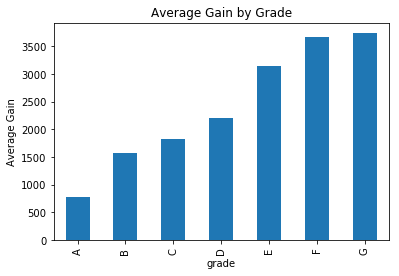

In [397]:
#create bar plot
var = RiskData.groupby('grade').gain.mean()
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Grade')
ax1.set_ylabel('Average Gain')
ax1.set_title('Average Gain by Grade')
var.plot(kind='bar')
plt.show()

In [405]:
#### evalue the recall
for (i in )
sum((RiskData['status'] * RiskSimu.iloc[:, j]))/(RiskData['status'].sum())

0.15098740475820246

In [414]:
recall = []
for j in range(1, (len(thresh) +1)):
    recall.append(sum((RiskData['status'] * (1-RiskSimu.iloc[:, j])))/(RiskData['status'].sum()))

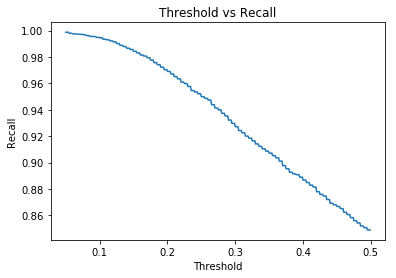

In [415]:
#plot the average gain
plt.plot(thresh, recall )
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.title('Threshold vs Recall')
plt.show()